In [1]:
### Imports for notebook ###

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

%matplotlib inline

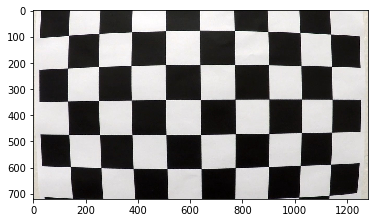

In [2]:
# Read in a calibration image - for comparison later
cal_img_sample = mpimg.imread('./camera_cal/calibration1.jpg')
plt.imshow(cal_img_sample)

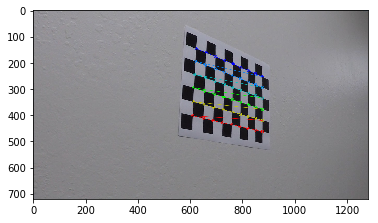

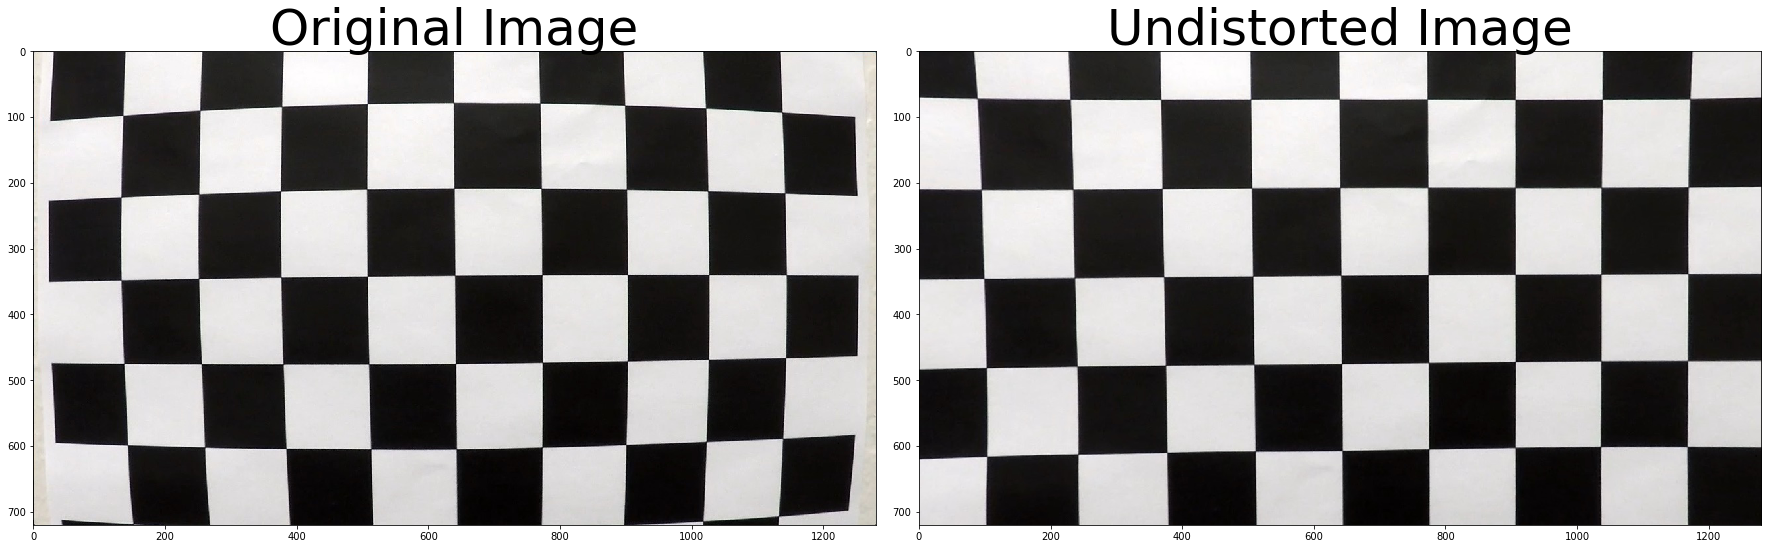

In [448]:
# Calibration and distortion correction function

# Read in and make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Arrays to store object points and image points from all the images

objpoints = []  # 3D points in real world space
imgpoints = []  # 2D points in image plane

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ...., (7,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x,y coordinates

for i in images:
    # read in each image
    img = mpimg.imread(i)

    # Convert image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray,(9,6),None) 
 
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
    
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img,(9,6), corners, ret)
        plt.imshow(img)
mpimg.imsave('./output_images/drawcorners.jpg',img)
    
def cal_and_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undist

undistorted = cal_and_undistort(cal_img_sample, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cal_img_sample)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
mpimg.imsave('./output_images/undistorted.jpg',undistorted)

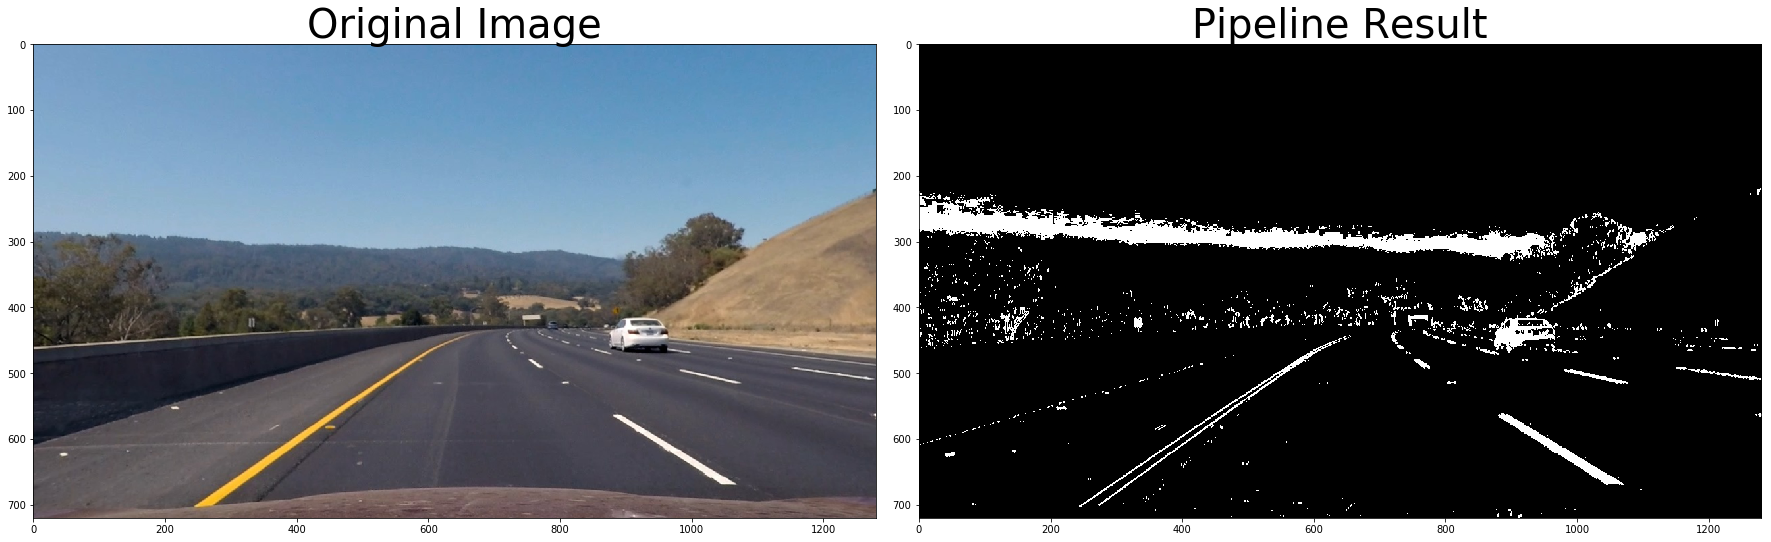

In [450]:
# Color & Gradient Thresholds: Pipeline Function

cam_image = mpimg.imread('./test_images/test3.jpg')
# plt.imshow(cam_image)
cal_cam_image = cal_and_undistort(cam_image,objpoints, imgpoints)

def pipeline(img, s_thresh=(180, 255), sx_thresh=(25, 255)): 
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(l_channel >= s_thresh[0]) & (l_channel <= s_thresh[1])] = 1
   
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

## pipeline2 for threshold testing - not used

def pipeline2(img, sobel_kernel= 3, s_thresh=(60, 200)): #Best result values st 200,255;sx 25,255
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Threshold color channel
    s_binary = np.zeros_like(l_channel)
    s_binary[(l_channel >= s_thresh[0]) & (l_channel <= s_thresh[1])] = 1

    return s_binary 
    
pipeline_result = pipeline(cal_cam_image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(cal_cam_image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(pipeline_result,cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

mpimg.imsave('./output_images/calibrated.jpg',cal_cam_image)
mpimg.imsave('./output_images/pipeline.jpg',pipeline_result, cmap='gray')

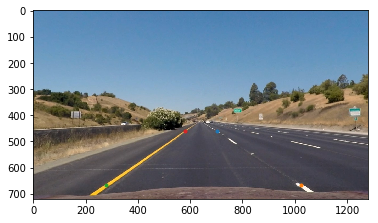

In [451]:
# Perspective Transform

imagePT = mpimg.imread('./test_images/straight_lines1.jpg')

cal_imagePT = cal_and_undistort(imagePT, objpoints, imgpoints)

mpimg.imsave('./output_images/calibratedPT.jpg',cal_imagePT)

plt.imshow(cal_imagePT)
plt.plot(704,462,'.') # top right  (750,490)
plt.plot(1025,665,'.') # bottom right (1025,665)
plt.plot(280,665,'.') # bottom left (280,665)
plt.plot(581,462,'.') # top left (540,490)


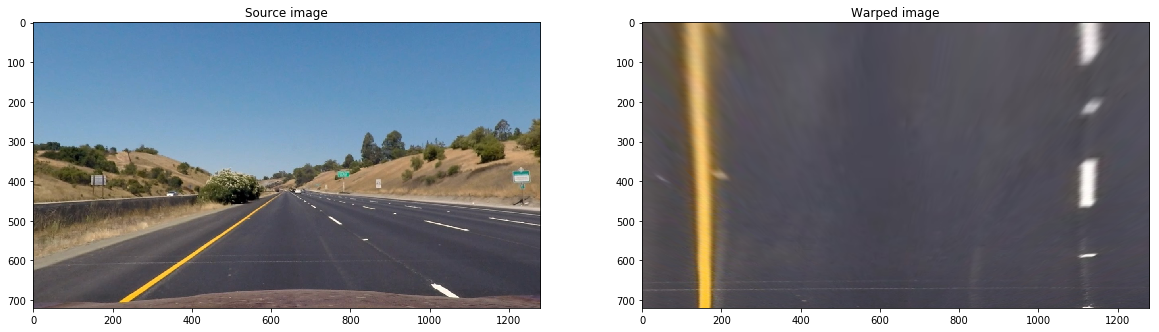

In [453]:
# Define perspective transform function
def warp(image):
    
    # Define calibration box in source (original) and destination (desired or warped) coordinates
    
    img_size = (image.shape[1], image.shape[0])
    #gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Four source coordinates
    src = np.float32(
        [[581, 462],
         [704, 462],
         [280, 665],
         [1025, 665]])
    offset = 150
    # Four desired coordinates
    dst = np.float32(
        [[offset, 0],
         [1280-offset, 0],
         [offset, 720],
         [1280- offset, 720]])

    
    # Compute the prespective transform, M
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Create warped images - uses linear interpolation
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

warped_imagePT = warp(cal_imagePT)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))

ax1.set_title('Source image')
ax1.imshow(cal_imagePT)
ax2.set_title('Warped image')
ax2.imshow(warped_imagePT)

mpimg.imsave('./output_images/warp.jpg',warped_imagePT)

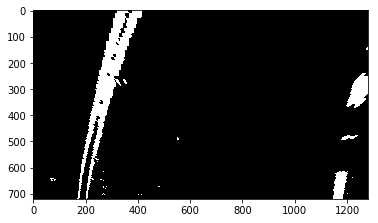

In [455]:
# Result to warp test

warped_result = warp(pipeline_result)
plt.imshow(warped_result,cmap='gray')

mpimg.imsave('./output_images/warped_result.jpg',warped_result, cmap= 'gray')

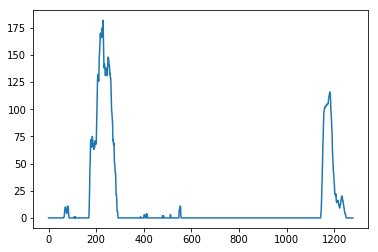

In [462]:
# Histogram Plotting

histogram = np.sum(warped_result[warped_result.shape[0]//2:,:], axis=0)
plt.plot(histogram)

plt.savefig('./output_images/histo.jpg')

In [437]:
## Please note code below was taken from lectures and change to produce a video output later

In [469]:

# Take a histogram of the bottom half of the image
binary_warped = warped_result

### Binary 
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 120
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

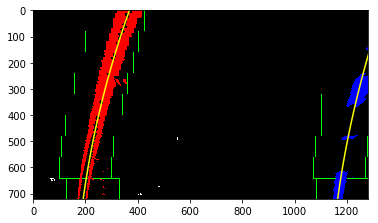

In [470]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.savefig('./output_images/swindow.jpg')

In [466]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

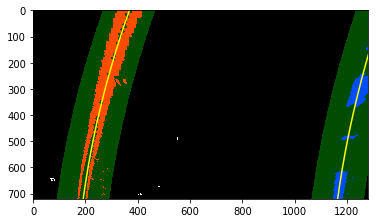

In [471]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.savefig('./output_images/fit.jpg')

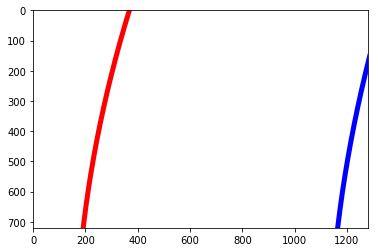

In [472]:


ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient

# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)

# Changes from lecture

leftx = np.array([(y**2)*quadratic_coeff# + #np.random.randint(-50, high=51) 
                              for y in ploty]) 
rightx = np.array([(y**2)*quadratic_coeff# + #np.random.randint(-50, high=51) 
                                for y in ploty]) 

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line

left_fit = np.polyfit(ploty, leftx, 2)
#left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2] ##
right_fit = np.polyfit(ploty, rightx, 2)
#right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] ##

# Plot up the fake data

mark_size = 3
#plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
#plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='red', linewidth=5)
plt.plot(right_fitx, ploty, color='blue', linewidth=5)
plt.gca().invert_yaxis() # to visualize as we do the images

In [473]:
# Radius of curvature
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48





1666.66666667 1666.66666667


In [474]:
# Correcting for scale (real world)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension ##30/720
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')




547.422422422 m 547.422422422 m


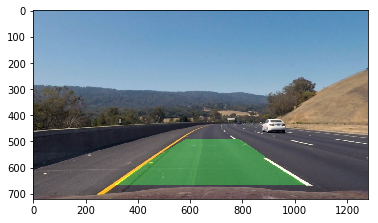

In [476]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))


# Four source coordinates
nsrc = np.float32(
        [[540, 490],
         [750, 490],
         [280, 665],
         [1025, 665]])

offset = 150
    # Four desired coordinates
ndst = np.float32(
        [[offset, 0],
         [1280-offset, 0],
         [offset, 720],
         [1280- offset, 720]])


nMinv = cv2.getPerspectiveTransform(ndst, nsrc)

# Warp the blank back to original image space using inverse perspective matrix (Minv)
                                                    #binary_warped.shape
newwarp = cv2.warpPerspective(color_warp, nMinv, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
# Combine the result with the original image
fresult = cv2.addWeighted(cal_cam_image, 1, newwarp, 0.3, 0)
plt.imshow(fresult)

mpimg.imsave('./output_images/warped_result.jpg',fresult)

In [477]:
### Code for video solution

In [478]:
### process image function

def process_image(image):

    
    # functions created earlier
    
    calibration = cal_and_undistort(image, objpoints, imgpoints)
    color_grad_thresh = pipeline(calibration)
    transp = warp(color_grad_thresh)
    
####################
# Take a histogram of the bottom half of the image
    binary_warped = transp

  ### Binary #####################################
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 120
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

  ###################################

        # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
  ###########################################  
    
    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
      
    
    #########################
    
         # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0) #(was out_img)
    
    
    #############################################
    
    
    # Generate some fake data to represent lane-line pixels

    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient

# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)

    leftx = np.array([(y**2)*quadratic_coeff# + np.random.randint(-50, high=51) 
                              for y in ploty]) ##30
    rightx = np.array([(y**2)*quadratic_coeff# + np.random.randint(-50, high=51) 
                                for y in ploty]) ##1300

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line

    left_fit = np.polyfit(ploty, leftx, 2)
  #  left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
  #  right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#################################################################

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Four source coordinates
    nsrc = np.float32(
        [[581, 462],
         [704, 462],
         [280, 665],
         [1025, 665]])

    offset = 150
    # Four desired coordinates
    ndst = np.float32(
        [[offset, 0],
         [1280-offset, 0],
         [offset, 720],
         [1280- offset, 720]])


    nMinv = cv2.getPerspectiveTransform(ndst, nsrc)
    
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv) ##binary_warped.shape
    newwarp = cv2.warpPerspective(color_warp, nMinv, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    # Combine the result with the original image
    fresult = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    #plt.imshow(fresult)
    
####################


    return fresult

In [479]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [487]:
proj_video_import = 'project_video.mp4'
proj_video_output = 'output.mp4'
clip = VideoFileClip(proj_video_import)#.subclip(4,12)
video_output = clip.fl_image(process_image)
%time video_output.write_videofile(proj_video_output, audio=False)


#proj_video_pathname = 'project_video.mp4'
#marked_proj_video_pathname = 'marked_project_video2.mp4'
#clip = VideoFileClip(proj_video_pathname).subclip(36,46)
#marked_proj_video = clip.fl_image(process_image)
#%time marked_proj_video.write_videofile(marked_proj_video_pathname, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4



 12%|█▏        | 152/1261 [02:03<14:57,  1.24it/s]


 24%|██▍       | 303/1261 [04:15<13:16,  1.20it/s]


 36%|███▌      | 454/1261 [06:22<11:03,  1.22it/s]


 48%|████▊     | 605/1261 [08:29<09:06,  1.20it/s]


 60%|█████▉    | 756/1261 [10:34<06:51,  1.23it/s]


 72%|███████▏  | 907/1261 [12:37<04:59,  1.18it/s]


 84%|████████▍ | 1057/1261 [14:42<02:46,  1.23it/s]


 96%|█████████▌| 1205/1261 [16:41<00:44,  1.26it/s]


100%|█████████▉| 1260/1261 [17:25<00:00,  1.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 16min 53s, sys: 57.2 s, total: 17min 51s
Wall time: 17min 26s
